# machine learning portfolio

In [83]:
#libraries inladen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
## dataframes inladen
SEED = 1337
test_df = pd.read_csv('test_c.csv')
train_df = pd.read_csv('train_c.csv')
display(test_df.head())
display(train_df.head())

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,1,85,66,29,0,26.6,0.351,31
1,4,0,137,40,35,168,43.1,2.288,33
2,13,1,189,60,23,846,30.1,0.398,59
3,14,5,166,72,19,175,25.8,0.587,51
4,20,3,126,88,41,235,39.3,0.704,27


,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668,6,98,58,33,190,34.0,0.430,43,0
1,324,2,112,75,32,0,35.7,0.148,21,0
2,624,2,108,64,0,0,30.8,0.158,21,0
3,690,8,107,80,0,0,24.6,0.856,34,0
4,473,7,136,90,0,0,29.9,0.210,50,0


In [2]:
##functie defineren om accuracy te pakken
def get_clf_stats(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion


## opdracht 1: EDA

In [3]:
display(test_df.info())
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      154 non-null    int64  
 1   Pregnancies               154 non-null    int64  
 2   Glucose                   154 non-null    int64  
 3   BloodPressure             154 non-null    int64  
 4   SkinThickness             154 non-null    int64  
 5   Insulin                   154 non-null    int64  
 6   BMI                       154 non-null    float64
 7   DiabetesPedigreeFunction  154 non-null    float64
 8   Age                       154 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 11.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      614 non-null    int64  
 1   Pregnancies               614 non-null    int64  
 2   Glucose                   614 non-null    int64  
 3   BloodPressure             614 non-null    int64  
 4   SkinThickness             614 non-null    int64  
 5   Insulin                   614 non-null    int64  
 6   BMI                       614 non-null    float64
 7   DiabetesPedigreeFunction  614 non-null    float64
 8   Age                       614 non-null    int64  
 9   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 48.1 KB


None

### alle waardes zijn numeriek

In [4]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

train_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.542345,3.809446,120.465798,68.903909,20.456026,81.250814,31.929642,0.468096,33.265472,0.342020
std,222.135103,3.375544,31.959619,19.933385,16.063105,116.947384,8.136791,0.329203,11.851427,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,194.250000,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.238000,24.000000,0.000000
50%,380.500000,3.000000,115.000000,72.000000,23.000000,27.000000,32.150000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,99.000000,744.000000,67.100000,2.420000,72.000000,1.000000


In [5]:
train_df.isna().sum()

p_id                        0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### er zitten geen nans in de data dus het is geschikt voor machine learning

In [6]:
x_cols = train_df.columns[1:9]
x_cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

p_id                       -0.085877
Pregnancies                 0.222939
Glucose                     0.475325
BloodPressure               0.082771
SkinThickness               0.078982
Insulin                     0.124408
BMI                         0.272149
DiabetesPedigreeFunction    0.182245
Age                         0.233461
Outcome                     1.000000
Name: Outcome, dtype: float64


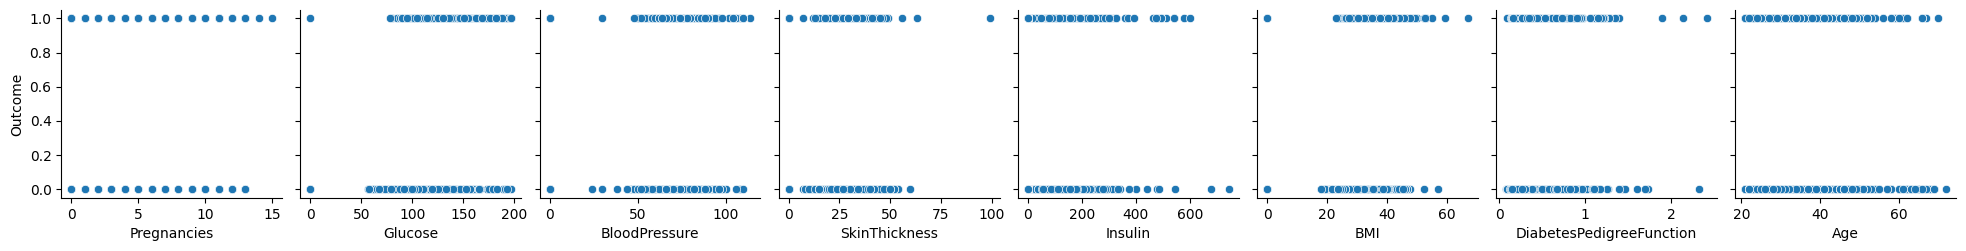

In [7]:
## relaties tussen variabelen laten zien
X = train_df[x_cols]
y = train_df['Outcome']

print(train_df.corr()['Outcome'])
fig = sns.pairplot(
    train_df,
    x_vars=x_cols,
    y_vars='Outcome'
)
plt.show()

## onderzoeken of we moeten standaardiseren en of er outliers in de data  zitten

In [8]:
feature_names = [cname for cname in train_df.loc[:,:'Age'].columns]

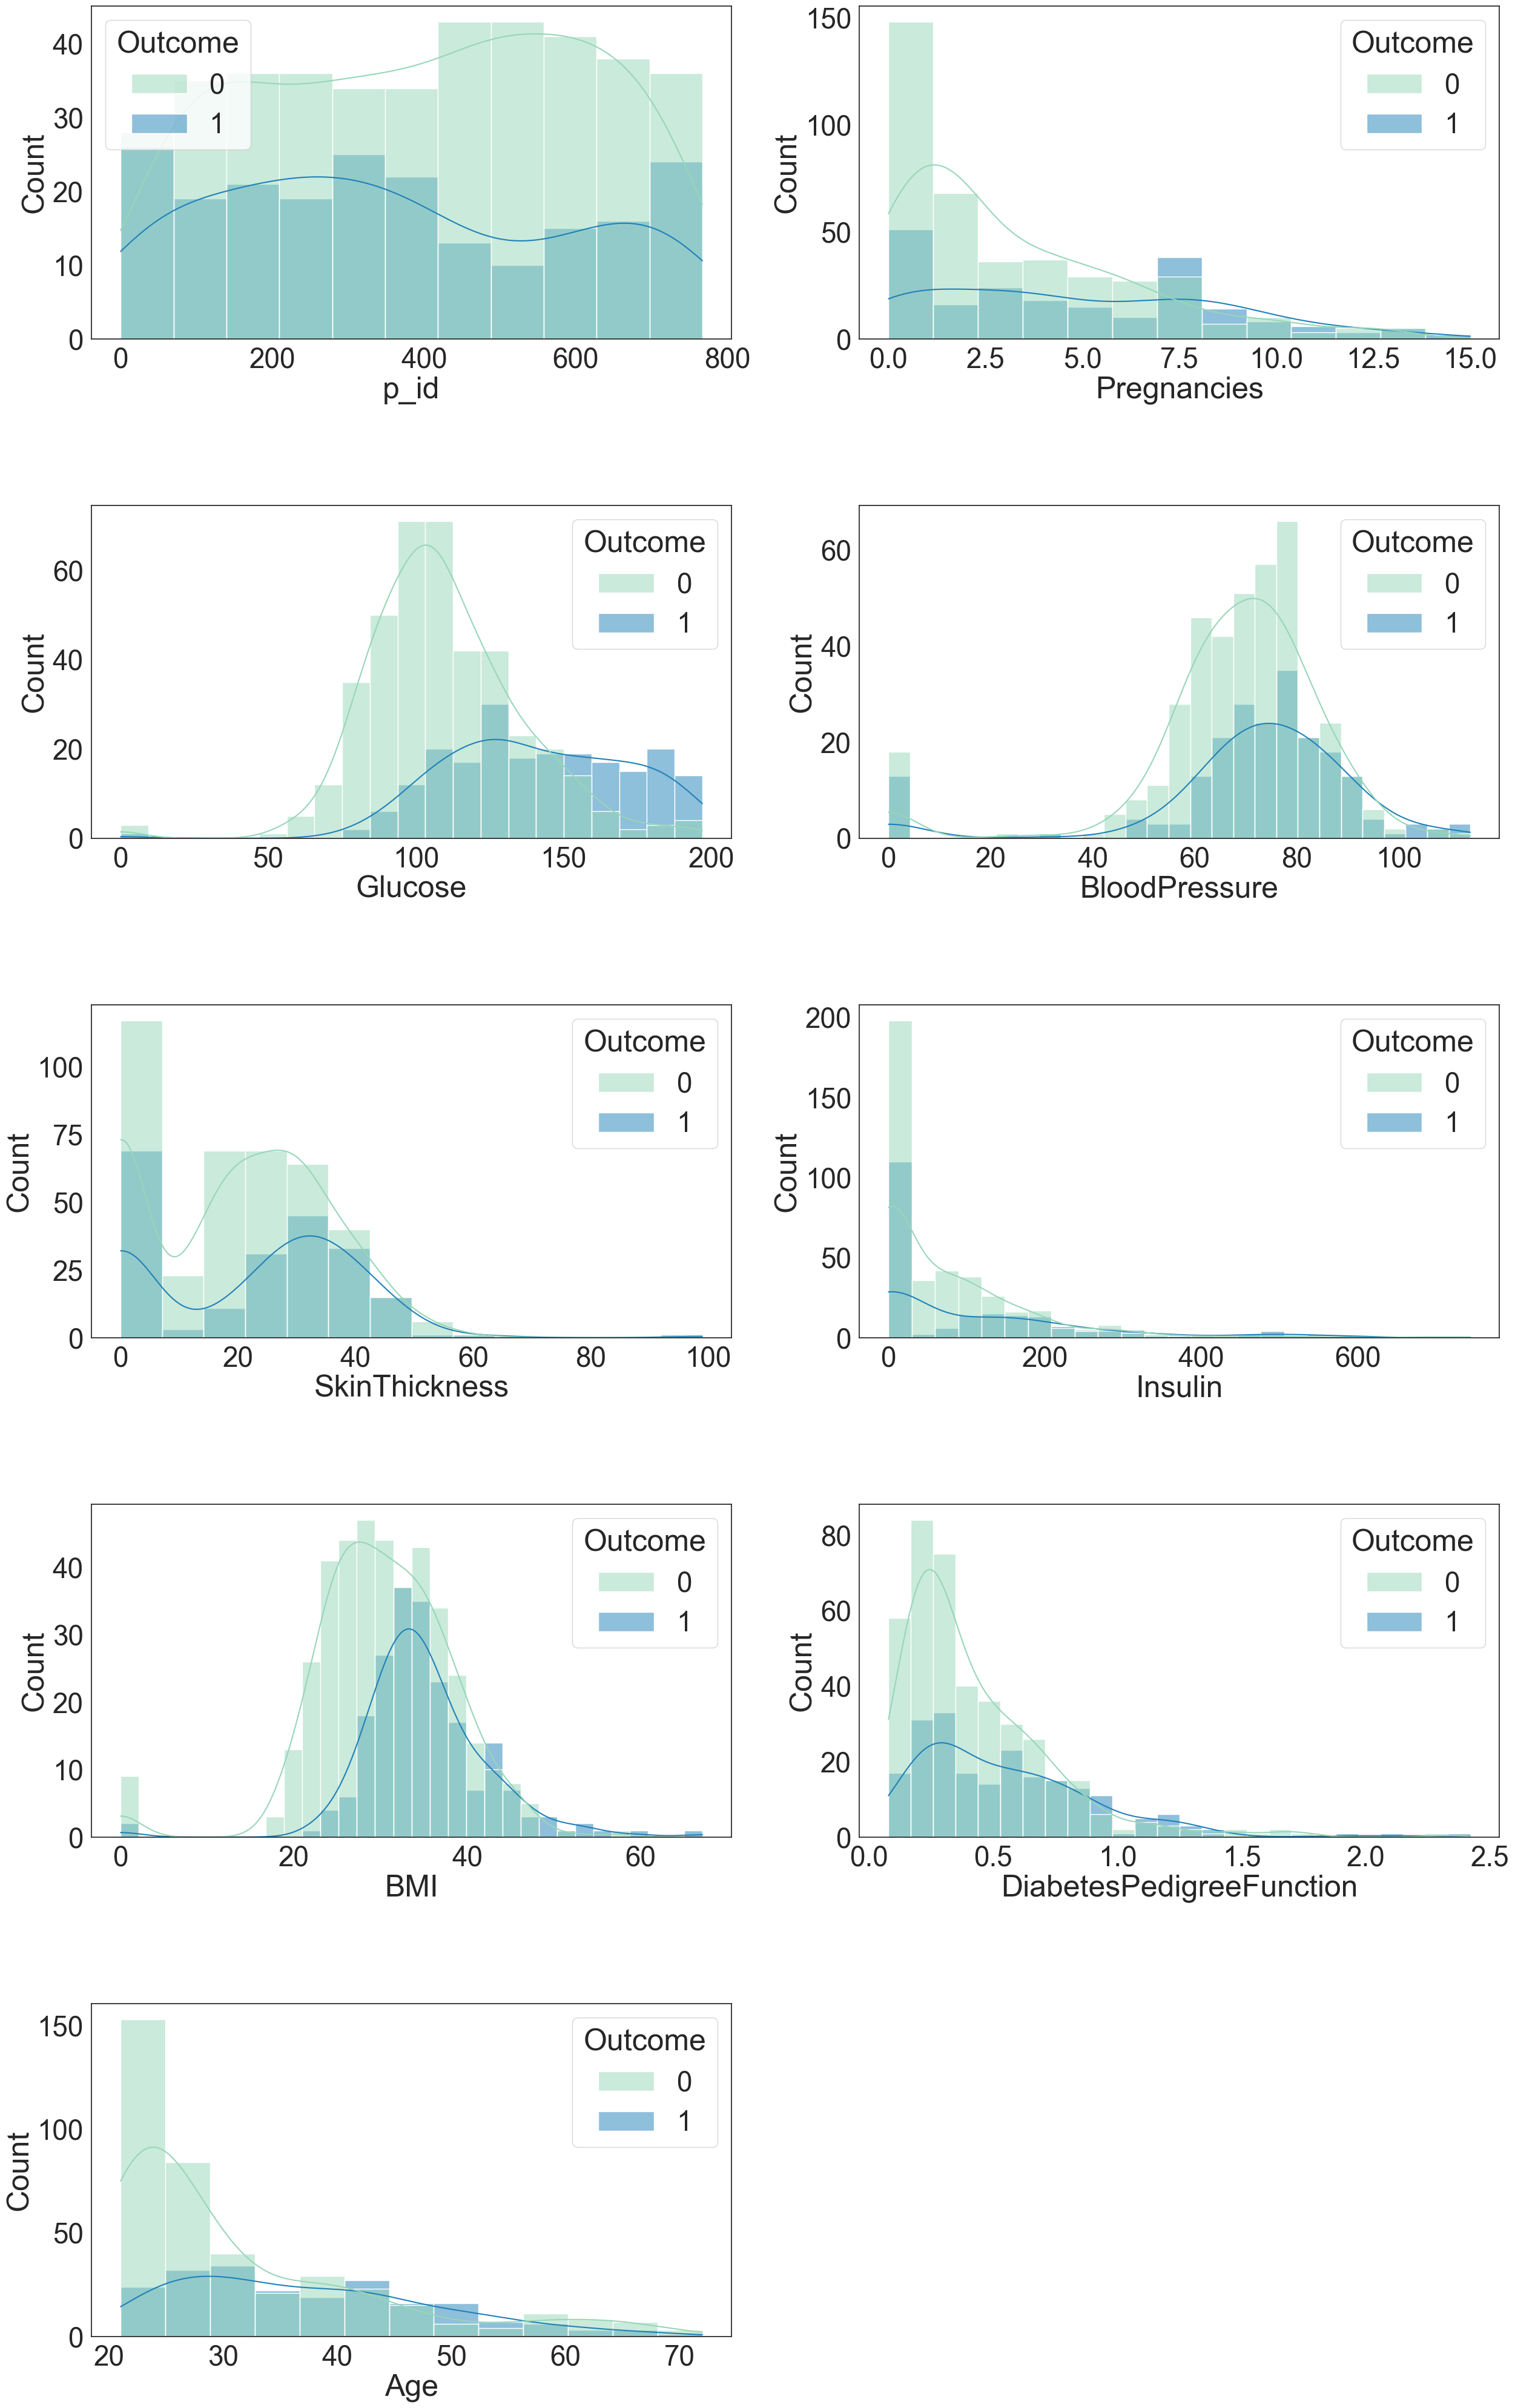

In [9]:
rcParams['figure.figsize'] = 30,50
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=train_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

### het is een goed idee om te standaardiseren omdat de data veel verschillende meetniveaus heeft. Ook hebben sommige datapunten veel nul waardes die daar niet horen.

In [10]:
## nul waardes uit de desbetreffende features vervangen met nan
train_df[['Glucose','BloodPressure','SkinThickness','BMI']] = train_df[['Glucose',
                                                                                 'BloodPressure','SkinThickness','BMI']].replace(0, np.NaN)

In [11]:
## alle nans imputen
imp_mean = IterativeImputer(random_state=SEED)
imputed = imp_mean.fit_transform(train_df)
train_df_imp = pd.DataFrame(imputed, columns=train_df.columns)
train_df_imp

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668.0,6.0,98.0,58.0,33.000000,190.0,34.0,0.430,43.0,0.0
1,324.0,2.0,112.0,75.0,32.000000,0.0,35.7,0.148,21.0,0.0
2,624.0,2.0,108.0,64.0,26.413781,0.0,30.8,0.158,21.0,0.0
3,690.0,8.0,107.0,80.0,20.606907,0.0,24.6,0.856,34.0,0.0
4,473.0,7.0,136.0,90.0,27.655117,0.0,29.9,0.210,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...
609,384.0,1.0,125.0,70.0,24.000000,110.0,24.3,0.221,25.0,0.0
610,224.0,1.0,100.0,66.0,15.000000,56.0,23.6,0.666,26.0,0.0
611,729.0,2.0,92.0,52.0,26.128637,0.0,30.1,0.141,22.0,0.0
612,630.0,7.0,114.0,64.0,24.575839,0.0,27.4,0.732,34.0,1.0


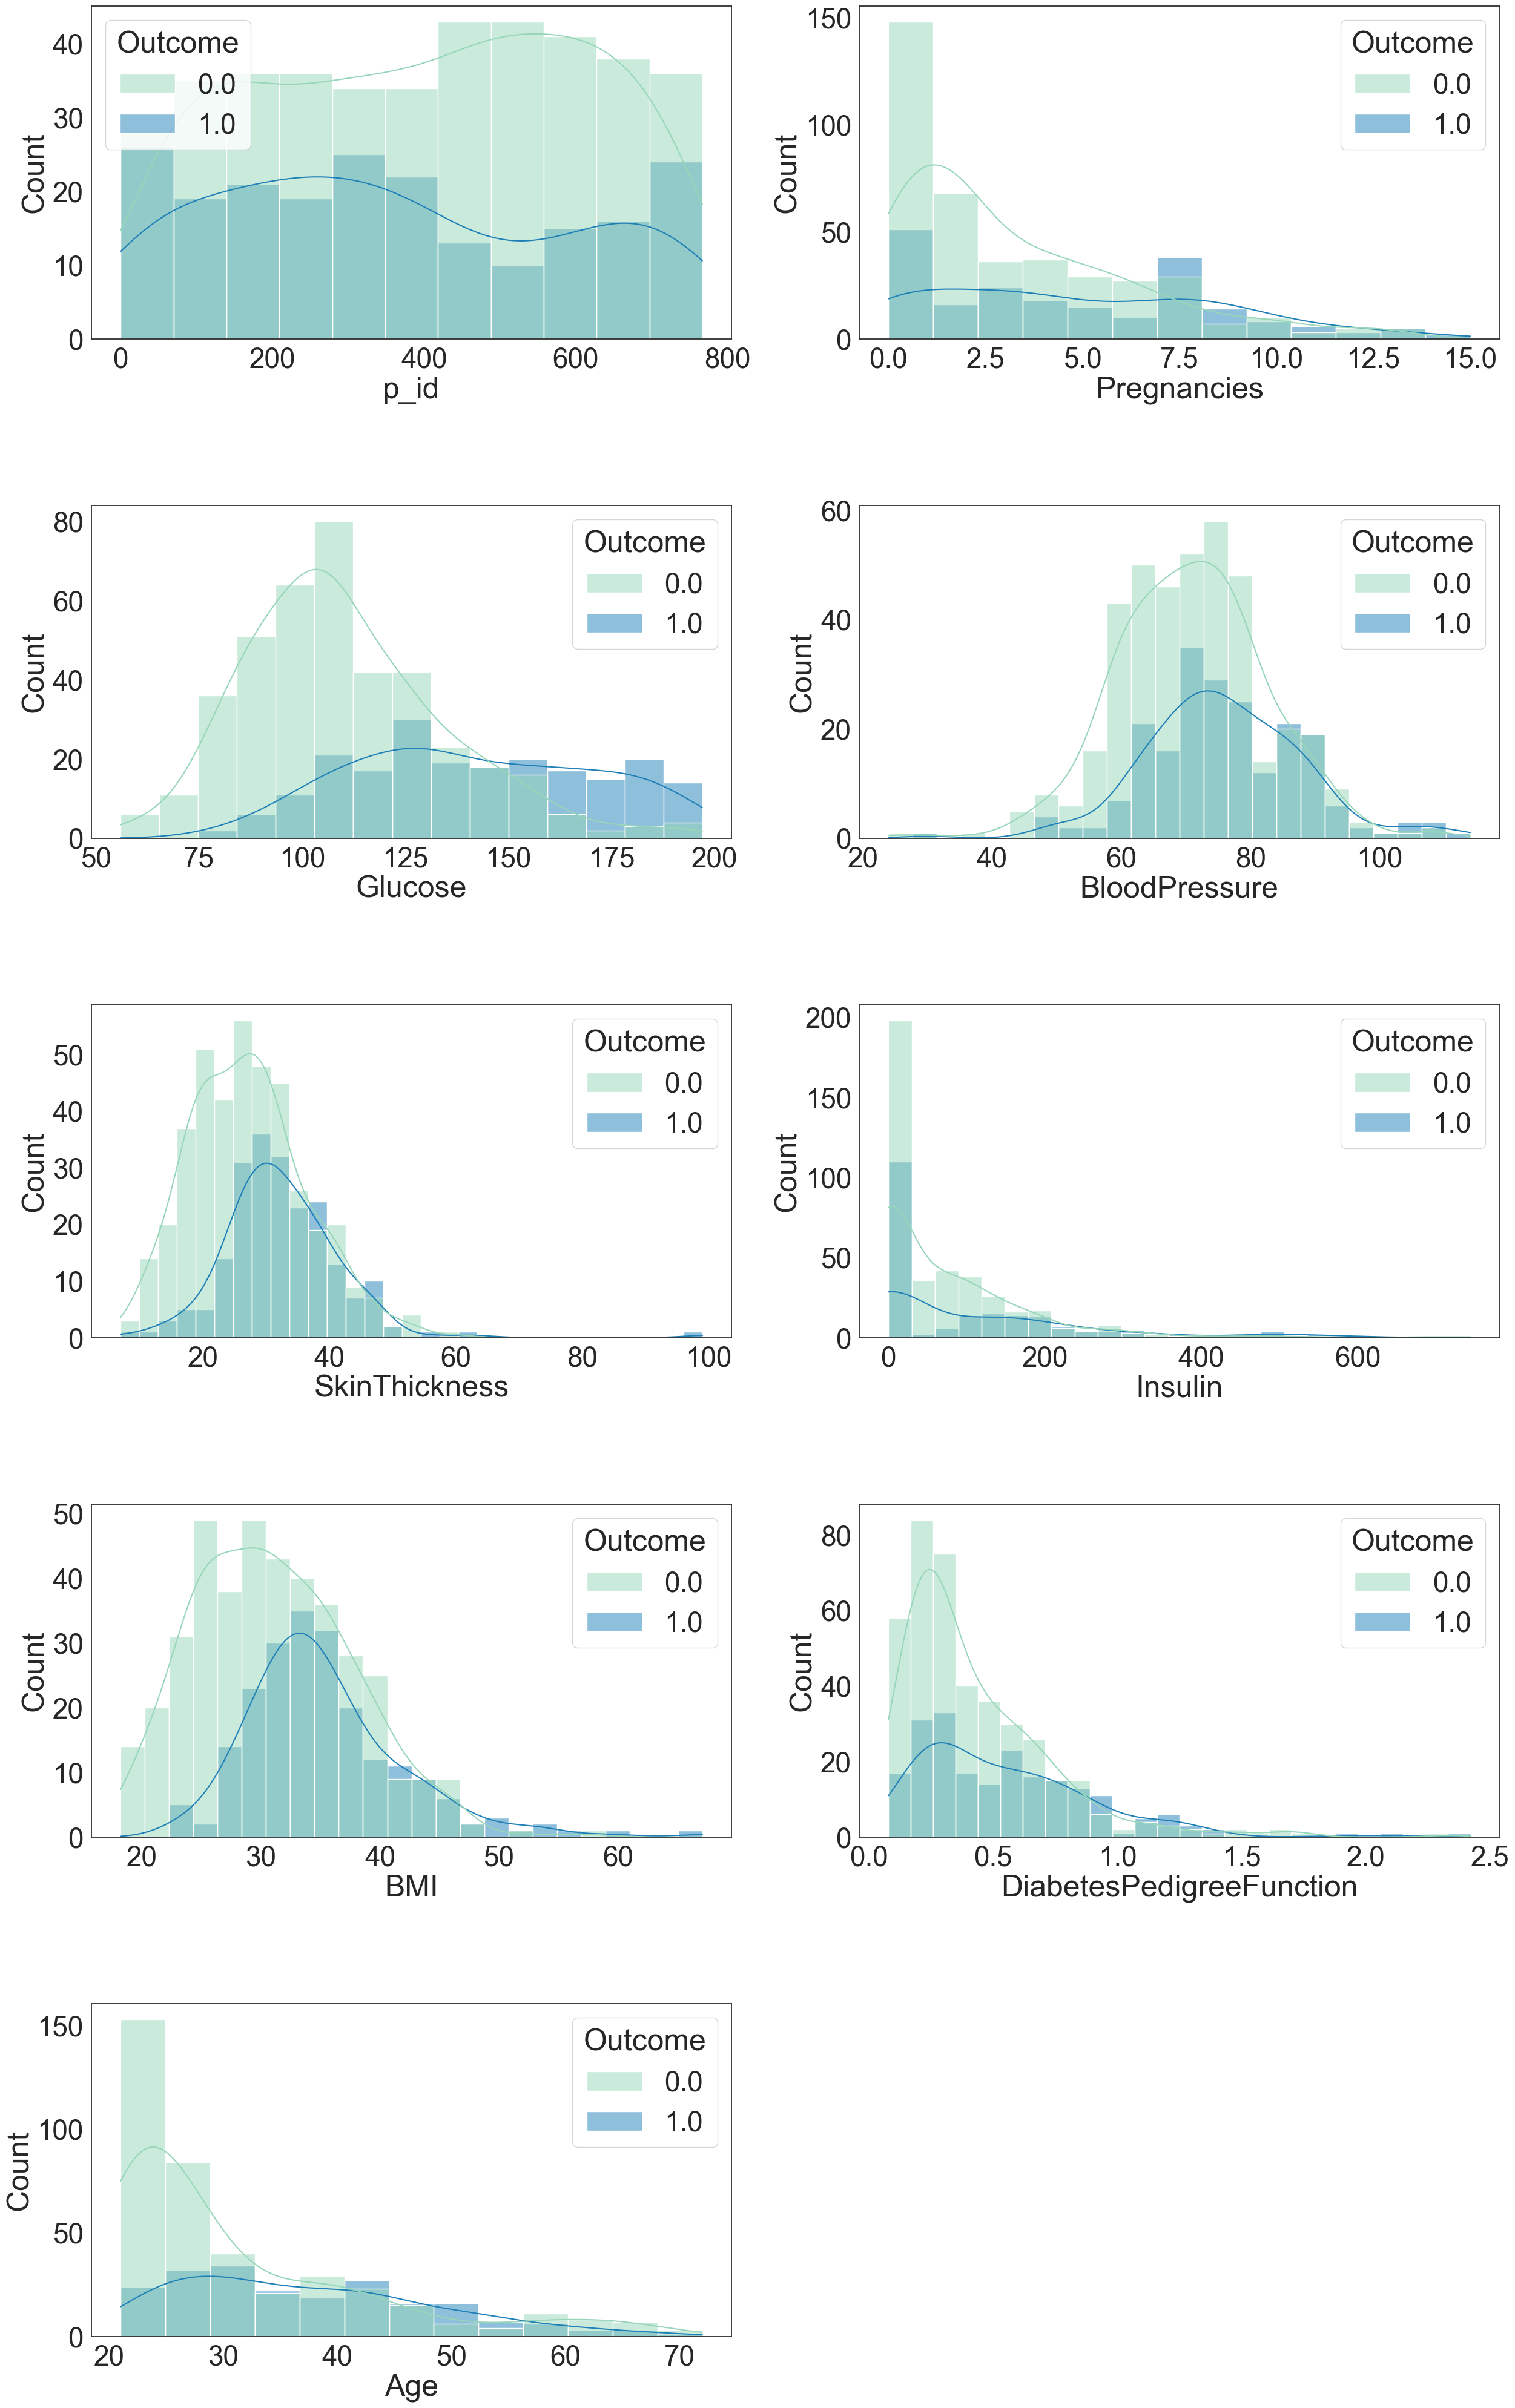

In [12]:
rcParams['figure.figsize'] = 30,50
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=train_df_imp, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

In [13]:
## standaardiseren van de data
scale = StandardScaler()
scaled_data = scale.fit_transform(train_df_imp[x_cols])
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.head()
train_df_imp['Pregnancies'] = scaled_data_df[0]
train_df_imp['Glucose'] = scaled_data_df[1]
train_df_imp['BloodPressure'] = scaled_data_df[2]
train_df_imp['SkinThickness'] = scaled_data_df[3]
train_df_imp['Insulin'] = scaled_data_df[4]
train_df_imp['BMI'] = scaled_data_df[5]
train_df_imp['DiabetesPedigreeFunction'] = scaled_data_df[6]
train_df_imp['Age'] = scaled_data_df[7]

# opdracht 2: Evaluatie

- De vorm van machine learning die we hier gebruiken is supervised learning. Er worden namelijk test sets gebruikt om een model te trainen
- We hebben met deze opdracht te maken met een classificatie probleem. bij dit soort problemen hebben we een aantal metrics om modellen te evalueren

De belangerijkste metrics zijn deze:
- Accuracy: Deze metric geeft aan hoe veel van de voorspellingen juist zijn
- precision: Deze metric word gebruikt om te meten hoe veel "true positives" je hebt ten opzichte van "false negatives"
- recall: Deze metric meet hoe veel positieve waardes daadwerkelijk positief zijn
- f1-score: Deze metric is het gemiddelde van precision en recall
- de eerder genoemde false positives en negatives zijn uit te beelden in een "confusion matrix" Deze laat zien of je voorspelling juist zijn en hoe de verdeling is tussen goede en slechte voorspellingen
- ook laat deze confusion matrix zien waar je model beter in is

Wij willen een zo hoog mogelijke recall score omdat we "false negatives" willen minimaliseren.

## opdracht 3: modelleren

In [14]:
##X en y maken voor models
X = train_df_imp[x_cols]
y = train_df_imp['Outcome']

#### logistic regression

In [15]:
# logreg model maken en alle params voor tuning
logreg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [16]:
## tunen van het model en best paramaters printen 
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=SEED)
grid_search = GridSearchCV(estimator = logreg, param_grid = grid, n_jobs = -1, cv=cv, scoring ='accuracy')
grid_result = grid_search.fit(X, y)
print(grid_result.best_params_)

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


beste parameters zijn dus: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [17]:
## tuned logreg model met de beste parameters
logreg_tuned = LogisticRegression(**grid_result.best_params_, random_state=SEED).fit(X,y)

In [18]:
cross_val_score(logreg_tuned, X, y, cv = 10).mean()

0.77374405076679

#### Decision Tree

In [19]:
# decision tree model maken en alle params voor tuning
dt = DecisionTreeClassifier(random_state=SEED)
criterions = ['gini', 'entropy', 'log_loss']
splitters = ['best', 'random']
depths = [1, 5, 10, 100, None]
samples = [2, 5, 10]

In [20]:
## tunen van het model en best paramaters printen 
grid = dict(criterion = criterions, splitter = splitters, max_depth = depths, min_samples_split = samples)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
grid_search = GridSearchCV(estimator= dt, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X, y)
print(grid_result.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'random'}


beste parameters zijn dus: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'random'}

In [21]:
dt_tuned = DecisionTreeClassifier(**grid_result.best_params_, random_state=SEED).fit(X,y)

In [22]:
cross_val_score(dt_tuned, X, y, cv=100).mean()

0.7483333333333333

#### Random Forrest

In [25]:
# random forrest model maken en alle params voor tuning
# we kunnen hier bijna dezelfde params gebruiken als decision tree
rf = RandomForestClassifier(random_state=SEED)
criterions = ['gini', 'entropy', 'log_loss']
max_fts = ['sqrt', 'log2', None]
depths = [1, 5, 10, 100, None]
samples = [2, 5, 10]

In [26]:
## tunen van het model en best paramaters printen 
grid = dict(criterion = criterions, max_depth = depths, min_samples_split = samples, max_features = max_fts)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
grid_search = GridSearchCV(estimator= rf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X, y)
print(grid_result.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2}


beste params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2}

In [27]:
rf_tuned = RandomForestClassifier(**grid_result.best_params_, random_state=SEED).fit(X,y)

In [29]:
cross_val_score(rf_tuned, X, y, cv=100).mean()

0.7714285714285714

#### Gradient boosting

In [33]:
gb = GradientBoostingClassifier(random_state=SEED)
loss_func = ['log_loss', 'exponential']
rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]
estimators = [1, 2, 5, 10, 100]
sample = [0.1, 0.2, 0.5, 0.7, 0.9]
crit = ['friedman_mse', 'squared_error']
min_samples = [0.1, 0.2, 0.5, 0.7, 0.9]
fract_weight = [0.1, 0.2, 0.3, 0.4]
depths = [1, 5, 10, 100, None]
max_fts = ['sqrt', 'log2']

In [34]:
grid = dict(loss = loss_func, learning_rate = rate, n_estimators = estimators,
            subsample = sample,  criterion = crit, min_samples_split = min_samples,
            min_weight_fraction_leaf = fract_weight, max_depth = depths,
            max_features = max_fts)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
grid_search = GridSearchCV(estimator=gb, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X,y)
print(grid_result.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 100, 'subsample': 0.5}


beste params {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 100, 'subsample': 0.5}

In [39]:
params_dict = {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 
               'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1, 
               'n_estimators': 100, 'subsample': 0.5}
gb_tuned = GradientBoostingClassifier(**params_dict, random_state=SEED).fit(X,y)

In [40]:
cross_val_score(rf_tuned, X, y, cv=10).mean()

0.7721575885774723

#### ADA Boosting

In [42]:
ADA = AdaBoostClassifier(random_state=SEED)
estimators = [1, 2, 5, 10, 100]
rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]
algo = ['SAMME', 'SAMME.R']

In [43]:
grid = dict(n_estimators = estimators, learning_rate=rate, algorithm=algo)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
grid_search = GridSearchCV(estimator=ADA, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X,y)
print(grid_result.best_params_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}


beste params: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

In [44]:
ADA_tuned = AdaBoostClassifier(**grid_result.best_params_, random_state=SEED).fit(X,y)

In [45]:
cross_val_score(ADA_tuned, X, y, cv=10).mean()

0.7770227392913803

#### SVM

In [48]:
SVM = SVC(random_state=SEED)
c_values = [100, 10, 1.0, 0.1, 0.01]
kernels = ['poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
decision_function = ['ovo', 'ovr']

In [49]:
grid = dict(C=c_values, kernel=kernels, gamma=gammas,
            decision_function_shape=decision_function)
grid_search = GridSearchCV(estimator=SVM, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X,y)
print(grid_result.best_params_)

{'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'sigmoid'}


beste params: {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'sigmoid'}

In [58]:
SVM_tuned = SVC(**grid_result.best_params_, random_state=SEED, probability=True)

In [59]:
cross_val_score(SVM_tuned, X, y, cv=10).mean()

0.7672924378635642

#### Ensemble

In [60]:
eclf_hard = VotingClassifier(estimators=[('ada', ADA_tuned),
                                         ('lr', logreg_tuned),
                                         ('rf', rf_tuned),
                                         ('gb', gb_tuned),
                                         ('svm', SVM_tuned)], voting='hard').fit(X,y)
eclf_soft = VotingClassifier(estimators=[('ada', ADA_tuned),
                                         ('lr', logreg_tuned),
                                         ('rf', rf_tuned),
                                         ('gb', gb_tuned),
                                         ('svm', SVM_tuned)], voting='soft').fit(X,y)

In [62]:
hard_score = cross_val_score(eclf_hard, X, y, cv=100).mean()
soft_score = cross_val_score(eclf_soft, X, y, cv=100).mean()
print('Hard score: ', hard_score)
print('Soft score: ', soft_score)

Hard score:  0.7695238095238094
Soft score:  0.7759523809523808


### prediction

In [84]:
## nul waardes uit de desbetreffende features vervangen met nan
test_df[['Glucose','BloodPressure','SkinThickness','BMI']] = test_df[['Glucose',
                                                                                 'BloodPressure','SkinThickness','BMI']].replace(0, np.NaN)

In [85]:
## alle nans imputen
imp_mean = IterativeImputer(random_state=SEED)
imputed = imp_mean.fit_transform(test_df)
test_df_imp = pd.DataFrame(imputed, columns=test_df.columns)
test_df_imp.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.0,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
1,4.0,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0
2,13.0,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0
3,14.0,5.0,166.0,72.0,19.0,175.0,25.8,0.587,51.0
4,20.0,3.0,126.0,88.0,41.0,235.0,39.3,0.704,27.0


In [86]:
## standaardiseren van de data
scale = StandardScaler()
scaled_data = scale.fit_transform(test_df_imp[x_cols])
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.head()
test_df_imp['Pregnancies'] = scaled_data_df[0]
test_df_imp['Glucose'] = scaled_data_df[1]
test_df_imp['BloodPressure'] = scaled_data_df[2]
test_df_imp['SkinThickness'] = scaled_data_df[3]
test_df_imp['Insulin'] = scaled_data_df[4]
test_df_imp['BMI'] = scaled_data_df[5]
test_df_imp['DiabetesPedigreeFunction'] = scaled_data_df[6]
test_df_imp['Age'] = scaled_data_df[7]
test_df_imp.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.0,-0.893792,-1.264507,-0.466746,-0.039825,-0.685277,-0.832356,-0.400743,-0.188144
1,4.0,-1.193018,0.446378,-2.563648,0.610073,0.870214,1.601216,5.309084,-0.012543
2,13.0,-0.893792,2.157263,-0.950647,-0.689723,7.147733,-0.316144,-0.262198,2.270269
3,14.0,0.303112,1.400525,0.017154,-1.122988,0.935026,-0.950348,0.294930,1.567865
4,20.0,-0.295340,0.084460,1.307556,1.259971,1.490559,1.040757,0.639819,-0.539346


In [87]:
p_id = test_df['p_id']
test_df_imp = test_df_imp.drop('p_id', axis=1)

In [89]:
#prediction maken
pred = eclf_soft.predict(test_df_imp)

In [95]:
pred_df = pd.DataFrame(pred)
p_id_df = pd.DataFrame(p_id)
ans = pd.concat([p_id_df, pred_df], axis=1)
ans = ans.rename(columns = {0: 'p_id', 0: 'Outcome'})
ans.to_csv('Submission.csv', index = False)